# Toronto COVID cases by neighborhood

##  1.Introduction/Business Problem

During the COVID pandemic, all governments implemented several rules and restrictions in order to mitigate the outbreaks of the disease, these restrictions were usually defined based on the type of business and industry of the venues.

In this notebook I will try to rate the efficacy of the restrictions put in place by the government in the city of Toronto, by analyzing the data of the total COVID cases and the type of venues, all segmented by Postal Code and neighborhood.

The target audience would be all the involved government dependencies (Commerce, Health, City Planning) which could determine if the imposed restrictions did work and if any of these should be kept in place. Also, to define a workbook for future pandemics.

## 2.Data

### 2.1 Data Sources

**2.2.1 Toronto neighborhood data**

I will continue to use the neighborhood data from the wikipedia page which was used in the previous weeks:
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Using this data and the geocoder library, I will create a dataset with the following features:

PostalCode | Borough | Neighborhood | Latitude | Longitude
-----|-----|-----|-----|-----
M3A | North York | Parkwoods | 43.75245 | -79.32991
M4A | North York | Victoria Village | 43.73057 | -79.31306

**2.1.2 COVID-19 Cases in Toronto**

For the COVID cases in Toronto I will use the dataset provided by the Toronto city goverment in their Open Data portal:
https://open.toronto.ca/dataset/covid-19-cases-in-toronto/

An example of the dataset is below, wihch includes all the requiered features for the analysis (age, postal code, neighborhood)

_id  | Assigned_ID |Outbreak Associated | Age Group | Neighbourhood Name | FSA | Source of Infection | Classification | Episode Date | Reported Date | Client Gender | Outcome | Currently Hospitalized | Currently in ICU | Currently Intubated | Ever Hospitalized | Ever in ICU | Ever Intubated
-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----
3326211 |99865 |Sporadic| 19 and younger| Thorncliffe Park| M4H| Household Contact| CONFIRMED| 2021-02-24| 2021-02-25| FEMALE| RESOLVED| No| No| No |  No |  No |  No
3326212 |  99866 |  Sporadic |  40 to 49 Years |  Taylor-Massey |  M4C |  Household Contact |  CONFIRMED |  2021-02-24 |  2021-02-25 |  FEMALE |  RESOLVED |  No |  No |  No |  No |  No |  No 


**2.1.3 Canada demographic data by Postal Code (2016 Census)**

To have a better insights of the data, I will use the demographics data from 2016 census (latest data avilable) from the Canada government statistics page:
https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/CompFile.cfm?Lang=Eng&T=1201&OFT=FULLCSV

An example of the dataset is below, wihch includes the total population by postal code.

Geographic code | Geographic name | Province or territory | Incompletely enumerated Indian reserves and Indian settlements, 2016 | Population, 2016 | Total private dwellings, 2016 | Private dwellings occupied by usual residents, 2016
-----|-----|-----|-----|-----|-----|-----
01 | Canada |  | T | 35151728 | 15412443 | 14072079
A0A | A0A | Newfoundland and Labrador |  | 46587 | 26155 | 19426
A0B | A0B | Newfoundland and Labrador |  | 19792 | 13658 | 8792

**2.1.4 Foursquare API**

I will use the Foursquare API to gather the data of venues by neighborhood and define the most popular categories in each neighborhood

### 2.2 Data Gathering and Wrangling

First I will import all the required libraries (BeautifulSoup, pandas, numpy, requests, geocoder, folium, matplotlib) and define my foursquare CLIENT_ID and CLIENT_SECRET in a hidden cell.

In [1]:
# The code was removed by Watson Studio for sharing.

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=b5b8ca69193d55ccd79f54847c989af6732aa0c05bcee54be27e2051e8b9a42e
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/

#### 2.1.1 Toronto neighborhood data
First, let's import the Toronto neighborhood data

In [2]:
#Obtain html code with beutifulsoup and requests modules
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data  = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")

#Parse html table into a pandas dataframe
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
#Code to replace additional data in the table to the correct neighborhood
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.shape

(103, 3)

Let's add the latitude and longitude to each neighborhood

In [3]:
#Create new dataframe to add latitude and longitude per neighborhood
column_names = ['PostalCode','Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
print('Obtaining neighborhoods latitude and longitude: ', end='')
#Add latitude and longitude to each neighborhood and append it to the new dataframe
for index,neighborhood in df.iterrows():
    
    postal_code= neighborhood['PostalCode']
    borough = neighborhood['Borough']
    neighborhood = neighborhood['Neighborhood']
       
    lat_lng_coords = None
    while(lat_lng_coords is None):
    #geocoder.google was not retrieving any coordenates
     g = geocoder.arcgis ('{}, Toronto, Ontario'.format(postal_code))
     lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    print(' .', end='')
    neighborhoods = neighborhoods.append({'PostalCode': postal_code,
                                            'Borough': borough,
                                            'Neighborhood': neighborhood,
                                            'Latitude': latitude,
                                            'Longitude': longitude}, ignore_index=True)

print(' done.')

Obtaining neighborhoods latitude and longitude:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [4]:
neighborhoods.head(5)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Queen's Park,Ontario Provincial Government,43.66253,-79.39188


#### 2.1.2 COVID-19 Cases in Toronto
We will import the COVID-19 Cases in Toronto from the goverment portal.

In [5]:
path='https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/e5bf35bc-e681-43da-b2ce-0242d00922ad?format=csv'
toronto_cases = pd.read_csv(path)
toronto_cases.shape

(170621, 18)

In [6]:
toronto_cases.head(5)

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,3400296,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,3400297,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,3400298,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,3400299,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,3400300,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


We will remove all the records that do not have a value for the FSA feature (Forward sortation area i.e. first three characters of postal code, based on the case's primary home address)

In [7]:
toronto_cases.dropna(subset=['FSA'], inplace=True)
toronto_cases.shape

(169280, 18)

Let's group the cases total by Postal Code and Episode Date

In [8]:
toronto_cases_grouped_by_date = toronto_cases.groupby(["FSA", "Episode Date"])["Classification"].count().reset_index()
toronto_cases_grouped_by_date.rename(columns={"Classification": "Total_COVID_Cases"},inplace=True)
toronto_cases_grouped_by_date.head(5)

,FSA,Episode Date,Total_COVID_Cases
0,M0H,2021-04-11,1
1,M0M,2021-01-27,1
2,M1A,2021-04-08,1
3,M1B,2020-03-04,1
4,M1B,2020-03-16,2


In [9]:
toronto_cases_grouped_total = toronto_cases.groupby(["FSA"])["Classification"].count().reset_index()
toronto_cases_grouped_total.rename(columns={"Classification": "Total_COVID_Cases"}, inplace=True)

toronto_cases_grouped_total.head(5)

,FSA,Total_COVID_Cases
0,M0H,1
1,M0M,1
2,M1A,1
3,M1B,5724
4,M1C,2185


#### 2.1.3 Canada demographic data by Postal Code (2016 Census)
We will import the demographics data from 2016 census (latest data avilable) from the Canada goverment statistics page.

In [10]:
path='https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/CompFile.cfm?Lang=Eng&T=1201&OFT=FULLCSV'
canada_demographics = pd.read_csv(path)
canada_demographics.shape
canada_demographics.head()

,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,01,Canada,NaN,T,35151728.0,15412443.0,14072079.0
1,A0A,A0A,Newfoundland and Labrador,NaN,46587.0,26155.0,19426.0
2,A0B,A0B,Newfoundland and Labrador,NaN,19792.0,13658.0,8792.0
3,A0C,A0C,Newfoundland and Labrador,NaN,12587.0,8010.0,5606.0
4,A0E,A0E,Newfoundland and Labrador,NaN,22294.0,12293.0,9603.0


Let's merge the first three datasets to have a dataframe with the Postal Code, Neighborhood, COVID cases, Total Population features.

In [11]:
neighborhoods_merged = neighborhoods.merge(toronto_cases_grouped_total, left_on='PostalCode', right_on = 'FSA')
neighborhoods_merged = neighborhoods_merged.merge(canada_demographics[['Geographic code','Population, 2016']], left_on='PostalCode', right_on = 'Geographic code')
neighborhoods_merged.drop(columns=['FSA', 'Geographic code'],inplace=True)
neighborhoods_merged.rename(columns={"Population, 2016": "Population_2016"}, inplace=True)
#Delete data for neighborhoods with a population smaller than 100
neighborhoods_merged.drop(neighborhoods_merged[neighborhoods_merged.Population_2016 < 100].index, inplace=True)
neighborhoods_merged.shape

(96, 7)

In [12]:
neighborhoods_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total_COVID_Cases,Population_2016
0,M3A,North York,Parkwoods,43.75245,-79.32991,1900,34615.0
1,M4A,North York,Victoria Village,43.73057,-79.31306,995,14443.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,2331,41078.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,2165,21048.0
4,M9A,Etobicoke,Islington Avenue,43.66263,-79.52831,1835,35594.0
...,...,...,...,...,...,...,...
94,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649,1445,20822.0
96,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.65319,-79.51113,276,10787.0
97,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38133,1099,30472.0
98,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.63278,-79.48945,874,21299.0


Let's add a column to indicate the COVID cases per 1,000 population.

In [13]:
neighborhoods_merged['Cases_per_1000'] = (neighborhoods_merged.Total_COVID_Cases  / neighborhoods_merged.Population_2016) * 1000
neighborhoods_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total_COVID_Cases,Population_2016,Cases_per_1000
0,M3A,North York,Parkwoods,43.75245,-79.32991,1900,34615.0,54.889499
1,M4A,North York,Victoria Village,43.73057,-79.31306,995,14443.0,68.891505
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,2331,41078.0,56.745703
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,2165,21048.0,102.860129
4,M9A,Etobicoke,Islington Avenue,43.66263,-79.52831,1835,35594.0,51.553633
...,...,...,...,...,...,...,...,...
94,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649,1445,20822.0,69.397752
96,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.65319,-79.51113,276,10787.0,25.586354
97,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38133,1099,30472.0,36.065897
98,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.63278,-79.48945,874,21299.0,41.034790


### 2.1.4 Foursquare data
I will use the Foursquare API to gather the data of venues by neighborhood and define the 10 most popular venue categories in each neighborhood

In [14]:
#Function to retrieve the nearby venues per each neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
#Retrieve the venues for all the Toronto Postal Codes
print('Obtaining Postal Code venues: ', end='')
toronto_venues = getNearbyVenues(names=neighborhoods_merged['PostalCode'],
                                   latitudes=neighborhoods_merged['Latitude'],
                                   longitudes=neighborhoods_merged['Longitude']
                                  )

print(' end')

Obtaining Postal Code venues:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . end


In [16]:
toronto_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.75245,-79.32991,KFC,43.754387,-79.333021,Fast Food Restaurant
2,M3A,43.75245,-79.32991,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,M4A,43.73057,-79.31306,Stellar's Lenonade Stand,43.731507,-79.311712,Food Stand
4,M4A,43.73057,-79.31306,Wigmore Park,43.731023,-79.310771,Park


In [17]:
toronto_venues.groupby('PostalCode').count()

,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
PostalCode,,,,,,
M1B,3,3,3,3,3,3
M1C,1,1,1,1,1,1
M1E,4,4,4,4,4,4
M1G,5,5,5,5,5,5
M1H,1,1,1,1,1,1
...,...,...,...,...,...,...
M9N,6,6,6,6,6,6
M9P,6,6,6,6,6,6
M9R,4,4,4,4,4,4


Since some Postal Codes only return a handful of recommended venues, let's group the venues by it's main category. In order to get the parent category of each venue, I will call the categories API in Foursquare and insert the Parent Category column to our dataframe

In [18]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
results = requests.get(url).json()["response"]['categories']

categories_list = []
for main_category in results:
    mainname=main_category['name']
    print(mainname)
    categories_list.append([(
            mainname, 
            v['name']) for v in main_category['categories']])

    
categories_df = pd.DataFrame([item for category_list in categories_list for item in category_list])
categories_df.columns = ['Parent Category', 
                  'Venue Category']

categories_df.head()

Arts & Entertainment
College & University
Event
Food
Nightlife Spot
Outdoors & Recreation
Professional & Other Places
Residence
Shop & Service
Travel & Transport


,Parent Category,Venue Category
0,Arts & Entertainment,Amphitheater
1,Arts & Entertainment,Aquarium
2,Arts & Entertainment,Arcade
3,Arts & Entertainment,Art Gallery
4,Arts & Entertainment,Bowling Alley


In [19]:
toronto_venues_parent_category = toronto_venues.merge(categories_df, left_on= 'Venue Category', right_on=('Venue Category'))
toronto_venues_parent_category

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Parent Category
0,M3A,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park,Outdoors & Recreation
1,M4A,43.73057,-79.31306,Wigmore Park,43.731023,-79.310771,Park,Outdoors & Recreation
2,M9A,43.66263,-79.52831,Humber Valley Park,43.664825,-79.524999,Park,Outdoors & Recreation
3,M3B,43.74923,-79.36186,Ames Park,43.751868,-79.365473,Park,Outdoors & Recreation
4,M5C,43.65215,-79.37587,Berczy Park,43.648048,-79.375172,Park,Outdoors & Recreation
...,...,...,...,...,...,...,...,...
1324,M4Y,43.66659,-79.38133,Loaded Pierogi,43.664665,-79.380641,Polish Restaurant,Food
1325,M4Y,43.66659,-79.38133,Riddle Room,43.665881,-79.384936,Escape Room,Arts & Entertainment
1326,M4Y,43.66659,-79.38133,Flash,43.664319,-79.380190,Strip Club,Nightlife Spot
1327,M4Y,43.66659,-79.38133,Alexander Wood Statue,43.663702,-79.380301,Sculpture Garden,Outdoors & Recreation


In [20]:
#One hot encoding
toronto_onehot_parent = pd.get_dummies(toronto_venues_parent_category[['Parent Category']], prefix="", prefix_sep="")

# add PostalCode column back to dataframe
toronto_onehot_parent['PostalCode'] = toronto_venues_parent_category['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot_parent.columns[-1]] + list(toronto_onehot_parent.columns[:-1])
toronto_onehot_parent = toronto_onehot_parent[fixed_columns]

toronto_onehot_parent.shape

(1329, 10)

In [21]:
#Let's group rows by PostalCode and by taking the mean of the frequency of occurrence of each category
toronto_grouped_parent = toronto_onehot_parent.groupby('PostalCode').mean().reset_index()
toronto_grouped_parent

,PostalCode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M1B,0.0,0.0,0.500000,0.0,0.000000,0.0,0.0,0.500000,0.0
1,M1C,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0
2,M1E,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,0.333333,0.0
3,M1G,0.0,0.0,0.500000,0.0,0.250000,0.0,0.0,0.250000,0.0
4,M1H,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
89,M9N,0.0,0.0,0.600000,0.0,0.000000,0.0,0.0,0.400000,0.0
90,M9P,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
91,M9R,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.666667,0.0
92,M9V,0.0,0.0,0.545455,0.0,0.090909,0.0,0.0,0.363636,0.0


In [22]:
#Function to sort venue types in descending order, since some Postal Codes only have one venue category, I added a NA category to fill the top three positions
def return_most_common_venues(row, num_top_venues):
    nan_categories = pd.Series(data=[ np.nan, np.nan, np.nan], index=['NA','NA','NA'])
    row_categories = row.iloc[1:]
    row_categories = row_categories[row_categories > 0 ]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    row_categories_sorted = row_categories_sorted.append(nan_categories.astype('object'))                               

    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_parent_sorted = pd.DataFrame(columns=columns)
toronto_venues_parent_sorted['PostalCode'] = toronto_grouped_parent['PostalCode']

for ind in np.arange(toronto_grouped_parent.shape[0]):
    toronto_venues_parent_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped_parent.iloc[ind, :], num_top_venues)


In [24]:
toronto_venues_parent_sorted

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M1B,Shop & Service,Food,NA
1,M1C,Nightlife Spot,NA,NA
2,M1E,Shop & Service,Outdoors & Recreation,Food
3,M1G,Food,Shop & Service,Outdoors & Recreation
4,M1H,Shop & Service,NA,NA
...,...,...,...,...
89,M9N,Food,Shop & Service,NA
90,M9P,Food,NA,NA
91,M9R,Shop & Service,Food,NA
92,M9V,Food,Shop & Service,Outdoors & Recreation


Let's merge the top venues per Postal Code data with our previous dataframe

In [25]:
toronto_complete_data_parent = neighborhoods_merged.merge(toronto_venues_parent_sorted, left_on='PostalCode', right_on = 'PostalCode')
toronto_complete_data_parent.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total_COVID_Cases,Population_2016,Cases_per_1000,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,1900,34615.0,54.889499,Shop & Service,Outdoors & Recreation,Food
1,M4A,North York,Victoria Village,43.73057,-79.31306,995,14443.0,68.891505,Shop & Service,Outdoors & Recreation,Food
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,2331,41078.0,56.745703,Food,Shop & Service,Professional & Other Places
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,2165,21048.0,102.860129,Shop & Service,Food,Travel & Transport
4,M9A,Etobicoke,Islington Avenue,43.66263,-79.52831,1835,35594.0,51.553633,Shop & Service,Outdoors & Recreation,Food
5,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,5724,66108.0,86.585587,Shop & Service,Food,NA
6,M3B,North York,Don Mills North,43.74923,-79.36186,280,13324.0,21.014710,Shop & Service,Outdoors & Recreation,Food
7,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192,824,18628.0,44.234486,Food,Shop & Service,Outdoors & Recreation
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,616,12785.0,48.181463,Food,Shop & Service,Travel & Transport
9,M6B,North York,Glencairn,43.70687,-79.44812,2590,28522.0,90.807096,Food,Shop & Service,NA


Now we have all the data we require for the analysis

## 2.Methodology

Now that we collect all the data needed, we will cluster the Toronto's Postal Codes with the k-Means methodology, once clustered, we will try to predict the COVID cases pero 100 and confirm if there is a relation with the COVID transmission and the venue type in each Postal Code

k-Means clustering:

In [26]:
# k-Means clustering
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped_parent.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([1, 1, 1, 1, 0, 1, 0, 3, 3, 3, 1, 0, 0, 1, 0, 1, 2, 1, 2, 2, 3, 1,
       0, 3, 1, 1, 3, 0, 1, 3, 1, 1, 1, 1, 1, 2, 1, 3, 2, 1, 3, 3, 0, 1,
       2, 3, 1, 3, 2, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 0, 2, 3, 3, 3, 3, 0,
       3, 2, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 0, 0, 2, 1, 1, 0, 3, 1, 0,
       3, 1, 3, 0, 1, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 3 venues categories for each Postal Code.

In [27]:
# add clustering labels
toronto_venues_parent_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#Let's add 1 to each cluster, for visibility (no cluster 0)
toronto_venues_parent_sorted['Cluster Labels'] = toronto_venues_parent_sorted['Cluster Labels']  + 1

toronto_complete_data_parent = neighborhoods_merged.merge(toronto_venues_parent_sorted, left_on='PostalCode', right_on = 'PostalCode')
toronto_complete_data_parent.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total_COVID_Cases,Population_2016,Cases_per_1000,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,1900,34615.0,54.889499,2,Shop & Service,Outdoors & Recreation,Food
1,M4A,North York,Victoria Village,43.73057,-79.31306,995,14443.0,68.891505,2,Shop & Service,Outdoors & Recreation,Food
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,2331,41078.0,56.745703,4,Food,Shop & Service,Professional & Other Places
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,2165,21048.0,102.860129,1,Shop & Service,Food,Travel & Transport
4,M9A,Etobicoke,Islington Avenue,43.66263,-79.52831,1835,35594.0,51.553633,1,Shop & Service,Outdoors & Recreation,Food
5,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,5724,66108.0,86.585587,2,Shop & Service,Food,NA
6,M3B,North York,Don Mills North,43.74923,-79.36186,280,13324.0,21.014710,2,Shop & Service,Outdoors & Recreation,Food
7,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192,824,18628.0,44.234486,2,Food,Shop & Service,Outdoors & Recreation
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,616,12785.0,48.181463,2,Food,Shop & Service,Travel & Transport
9,M6B,North York,Glencairn,43.70687,-79.44812,2590,28522.0,90.807096,4,Food,Shop & Service,NA


Let's review each cluster:

In [28]:
print('Cluster 1')
toronto_complete_data_parent.loc[toronto_complete_data_parent['Cluster Labels'] == 1, toronto_complete_data_parent.columns[[1] + list(range(5, toronto_complete_data_parent.shape[1]))]]

Cluster 1


,Borough,Total_COVID_Cases,Population_2016,Cases_per_1000,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
3,North York,2165,21048.0,102.860129,1,Shop & Service,Food,Travel & Transport
4,Etobicoke,1835,35594.0,51.553633,1,Shop & Service,Outdoors & Recreation,Food
25,Scarborough,1913,24383.0,78.456302,1,Shop & Service,NA,NA
27,North York,2626,37011.0,70.951879,1,Shop & Service,NA,NA
37,Scarborough,3673,48434.0,75.835157,1,Shop & Service,Food,NA
47,North York,1432,11950.0,119.832636,1,Travel & Transport,Shop & Service,NA
57,Central Toronto,406,15330.0,26.484018,1,Shop & Service,NA,NA
58,Central Toronto,810,16610.0,48.765804,1,Shop & Service,NA,NA
62,North York,197,7843.0,25.117940,1,Shop & Service,Outdoors & Recreation,NA
67,Scarborough,2203,29858.0,73.782571,1,Shop & Service,NA,NA


In [29]:
print('Cluster 2')
toronto_complete_data_parent.loc[toronto_complete_data_parent['Cluster Labels'] == 2, toronto_complete_data_parent.columns[[1] + list(range(5, toronto_complete_data_parent.shape[1]))]]

Cluster 2


,Borough,Total_COVID_Cases,Population_2016,Cases_per_1000,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,North York,1900,34615.0,54.889499,2,Shop & Service,Outdoors & Recreation,Food
1,North York,995,14443.0,68.891505,2,Shop & Service,Outdoors & Recreation,Food
5,Scarborough,5724,66108.0,86.585587,2,Shop & Service,Food,NA
6,North York,280,13324.0,21.014710,2,Shop & Service,Outdoors & Recreation,Food
7,East York,824,18628.0,44.234486,2,Food,Shop & Service,Outdoors & Recreation
8,Downtown Toronto,616,12785.0,48.181463,2,Food,Shop & Service,Travel & Transport
11,Scarborough,2185,35626.0,61.331612,2,Nightlife Spot,NA,NA
13,East York,2174,46866.0,46.387573,2,Shop & Service,Food,Travel & Transport
14,Downtown Toronto,107,2951.0,36.258895,2,Food,Shop & Service,Travel & Transport
16,Etobicoke,2069,38291.0,54.033585,2,Shop & Service,Outdoors & Recreation,Food


In [30]:
print('Cluster 3')
toronto_complete_data_parent.loc[toronto_complete_data_parent['Cluster Labels'] == 3, toronto_complete_data_parent.columns[[1] + list(range(5, toronto_complete_data_parent.shape[1]))]]

Cluster 3


,Borough,Total_COVID_Cases,Population_2016,Cases_per_1000,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
15,York,993,24596.0,40.372418,3,Outdoors & Recreation,NA,NA
18,East Toronto,627,25044.0,25.035937,3,Outdoors & Recreation,NA,NA
26,North York,929,24497.0,37.923011,3,Residence,Outdoors & Recreation,NA
34,East York/East Toronto,1341,35738.0,37.523085,3,Outdoors & Recreation,NA,NA
38,North York,860,23852.0,36.055677,3,Outdoors & Recreation,Shop & Service,NA
43,North York,389,11717.0,33.199624,3,Outdoors & Recreation,NA,NA
64,Central Toronto,579,19423.0,29.810019,3,Outdoors & Recreation,NA,NA
69,Central Toronto,286,11394.0,25.100930,3,Outdoors & Recreation,Food,NA
86,Downtown Toronto,338,14561.0,23.212691,3,Outdoors & Recreation,NA,NA
90,Etobicoke,276,10787.0,25.586354,3,Outdoors & Recreation,NA,NA


In [31]:
print('Cluster 4')
toronto_complete_data_parent.loc[toronto_complete_data_parent['Cluster Labels'] == 4, toronto_complete_data_parent.columns[[1] + list(range(5, toronto_complete_data_parent.shape[1]))]]

Cluster 4


,Borough,Total_COVID_Cases,Population_2016,Cases_per_1000,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,Downtown Toronto,2331,41078.0,56.745703,4,Food,Shop & Service,Professional & Other Places
9,North York,2590,28522.0,90.807096,4,Food,Shop & Service,NA
10,Etobicoke,1703,32400.0,52.561728,4,Food,NA,NA
12,North York,2817,39153.0,71.948510,4,Food,Travel & Transport,NA
19,Downtown Toronto,292,9118.0,32.024567,4,Food,Shop & Service,Arts & Entertainment
20,York,2938,38041.0,77.232460,4,Food,Shop & Service,Outdoors & Recreation
24,Downtown Toronto,1068,32086.0,33.285545,4,Food,Shop & Service,Outdoors & Recreation
28,East York,1999,19688.0,101.533929,4,Food,Outdoors & Recreation,Travel & Transport
29,Downtown Toronto,94,2005.0,46.882793,4,Food,Shop & Service,Travel & Transport
35,Downtown Toronto,358,14545.0,24.613269,4,Food,Travel & Transport,Outdoors & Recreation


By examining each cluster, we could determine that the following categories distingish each cluster:

    Cluster 1: Shop & Service	
    Cluster 2: A combination of Food and Shop & Service	
    Cluster 3: Outdoors & Recreation
    Cluster 4: Food
    
Now, let's review the mean of Cases per 1000 for each cluster:

In [32]:
toronto_complete_data_parent.groupby('Cluster Labels').agg({'Cases_per_1000': ['mean']})

,Cases_per_1000
,mean
Cluster Labels,
1,63.049932
2,64.759912
3,31.381975
4,57.923008


Let's visualize this data in a folium map, the circle radius size is based in the Cases per 1000 indicator, and the circles are colored by cluster

In [33]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ON_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)



# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
    
for lat, lon, poi, cluster,Cases_per_1000 in zip(toronto_complete_data_parent['Latitude'], toronto_complete_data_parent['Longitude'], toronto_complete_data_parent['Neighborhood'], toronto_complete_data_parent['Cluster Labels'], toronto_complete_data_parent['Cases_per_1000']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=Cases_per_1000/6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
       
map_toronto

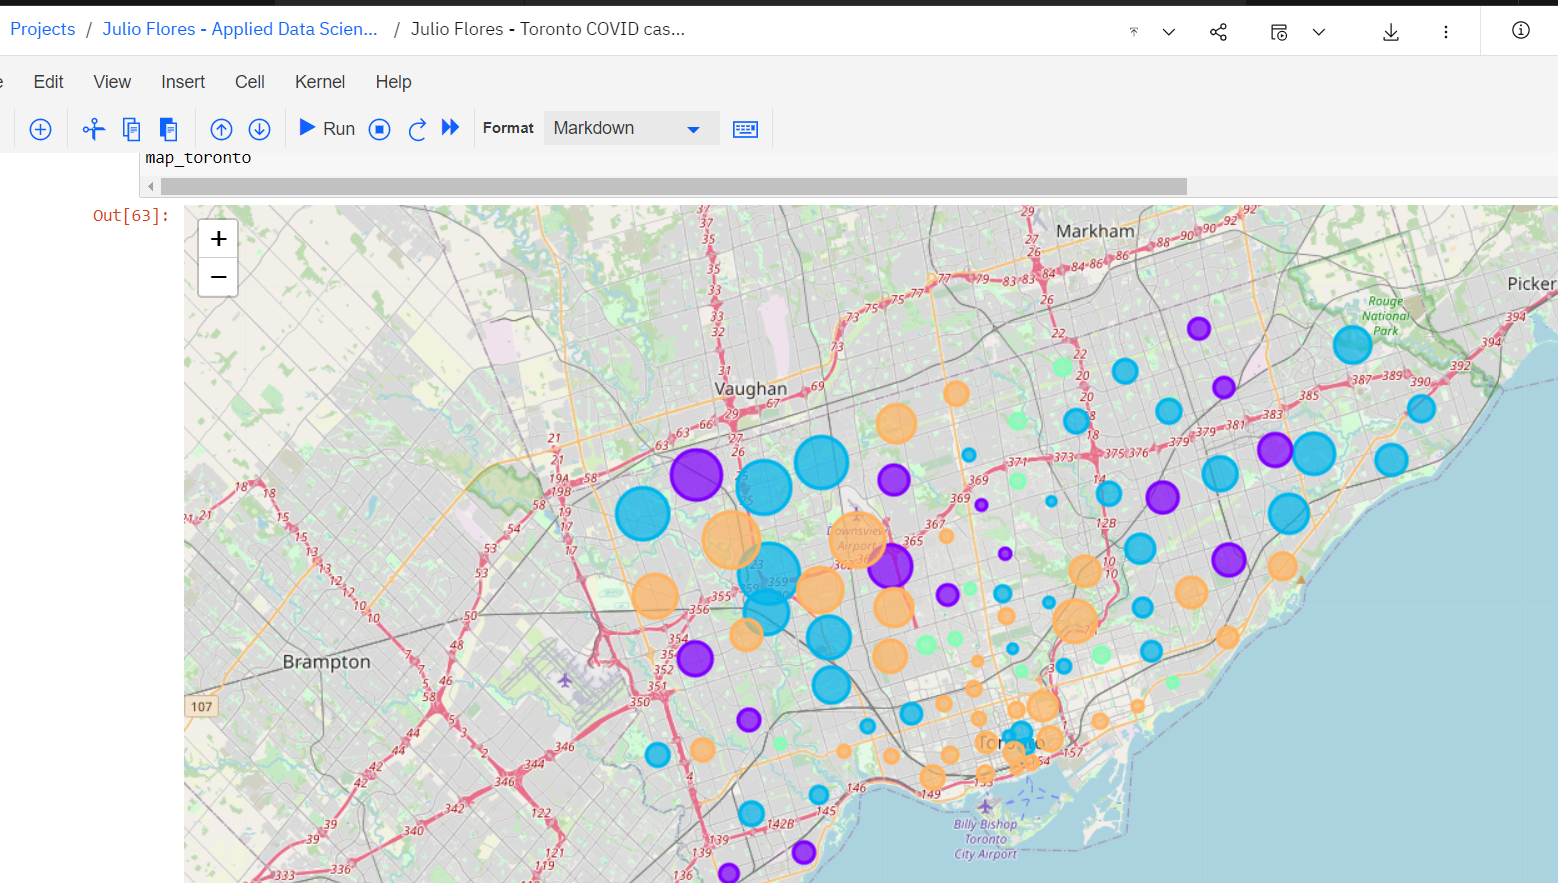
*(Folium map added as image due to issue to folium display in GitHub)*

- Cluster 1 - Purple  
- Cluster 2 - Blue  
- Cluster 3 - Green  
- Cluster 4 - Orange  


Let's add a time series plot to visualize the total cases in each cluster by date

In [34]:
toronto_cases_grouped_by_date = toronto_cases_grouped_by_date.merge(toronto_complete_data_parent[['PostalCode', 'Cluster Labels']], left_on='FSA', right_on = 'PostalCode')
toronto_cases_grouped_by_date_cluster = toronto_cases_grouped_by_date.groupby(["Cluster Labels", "Episode Date"])["Total_COVID_Cases"].sum().reset_index()
toronto_cases_grouped_by_date_cluster.head()

,Cluster Labels,Episode Date,Total_COVID_Cases
0,1,2020-02-20,1
1,1,2020-03-01,2
2,1,2020-03-03,1
3,1,2020-03-04,2
4,1,2020-03-05,4


In [35]:
toronto_cases_grouped_by_date_cluster["Episode Date"] = pd.to_datetime(toronto_cases_grouped_by_date_cluster["Episode Date"])
toronto_cases_grouped_by_date_cluster["Episode Date"].min(), toronto_cases_grouped_by_date_cluster["Episode Date"].max()

(Timestamp('2020-01-21 00:00:00'), Timestamp('2021-07-27 00:00:00'))

In [36]:
toronto_cases_by_date_cluster_col = toronto_cases_grouped_by_date_cluster.pivot(index="Episode Date", columns="Cluster Labels", values="Total_COVID_Cases")
toronto_cases_by_date_cluster_col.head()

Cluster Labels,1,2,3,4
Episode Date,,,,
2020-01-21,NaN,1.0,NaN,NaN
2020-01-22,NaN,2.0,NaN,NaN
2020-01-27,NaN,1.0,NaN,NaN
2020-02-01,NaN,NaN,1.0,NaN
2020-02-05,NaN,1.0,NaN,NaN


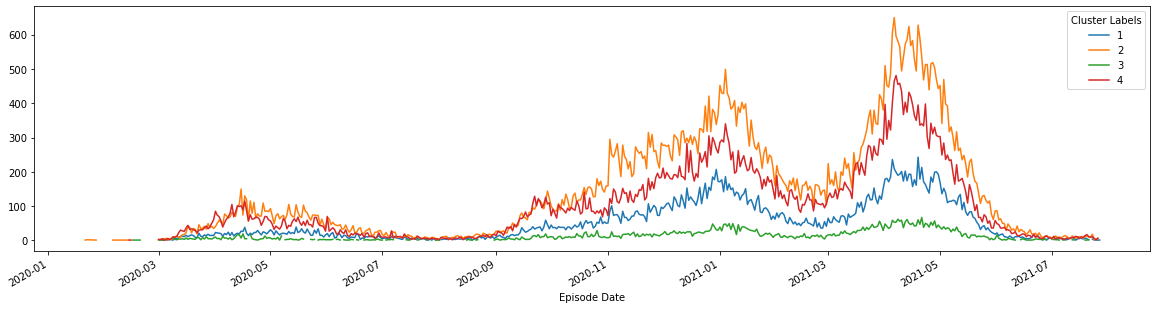

In [37]:
toronto_cases_by_date_cluster_col["2020-01-21":"2021-07-27"].plot(figsize=(20, 5));

## 3.Results

By looking at the above data, we can infer that the greater number of COVID cases per capita occurred in the neighborhoods which main category was related with Shop & Service. However, the greater number of total cases, occurred in the neighborhoods which Food venues are the first or second category.

As expected, the smaller share per capita occurred in the neighborhoods which main category is Outdoors & Recreation.

Based on this data, it seems that better rules and restrictions should have been applied to the Food
